## Importing Libraries

In [450]:
# Python basic Ml libraries
import numpy as np # Numerical processing
import pandas as pd

# Data visualization 
import matplotlib.pyplot as plt # For visulization 

#ML frameworks
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


# DL frameworks
import torch # Tensor computation
import torch.nn as nn # Neural Networks
import torch.optim as optim # Neural Nework optimizers
import torchtext # Text processing
import tqdm # For measuing progress
from torch.utils.data import Dataset, DataLoader


# Required additional libaries
import os
import gzip
import json
import requests
import collections



# Downloading dataset

In [451]:
DIR = './'

In [452]:
fileNames = pd.read_csv(os.path.join(DIR,"dataset_names.csv"))
display(fileNames)                       

,type,name
0,complete,goodreads_book_works.json.gz
1,complete,goodreads_book_authors.json.gz
2,complete,goodreads_book_series.json.gz
3,complete,goodreads_books.json.gz
4,complete,goodreads_book_genres_initial.json.gz
5,byGenre,goodreads_books_children.json.gz
6,byGenre,goodreads_books_comics_graphic.json.gz
7,byGenre,goodreads_books_fantasy_paranormal.json.gz
8,byGenre,goodreads_books_history_biography.json.gz
9,byGenre,goodreads_books_mystery_thriller_crime.json.gz


In [453]:
# Constructing url for donwloading the dataset
fileName_type_mapping = dict(zip(fileNames['name'].values, fileNames['type'].values))
fileName_url_mapping = {}

for fName in fileName_type_mapping:
    ftype = fileName_type_mapping[fName]
    if ftype == "complete":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/'+fName
        fileName_url_mapping[fName] = url
    elif ftype == "byGenre":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/'+fName
        fileName_url_mapping[fName] = url

In [454]:
def download_byName(fname, local_fileName):
    if fname in fileName_url_mapping:
        url = fileName_url_mapping[fname]

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            
            with open(local_fileName, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print("Dataset ", fname, " has been downloaded")
    else:
        print("Dataset ", fname, " cannot be found")

In [455]:
## Downloading the dataset without GUI
# outDir = './customerReviews'

# if not os.path.exists(outDir):
#     os.makedirs(outDir)
    
# output_path = os.path.join(outDir, 'goodreads_reviews_dedup.json.gz')
# download_byName('goodreads_reviews_dedup.json.gz', output_path)


## Importing Data

In [456]:
import dask.dataframe as dd

datasetPath = './customerReviews/goodreads_reviews_dedup.json.gz'

chunk_size = 10000  # Adjust the chunk size based on your system's memory capacity

# With pandas
chunks = pd.read_json(datasetPath, lines=True, compression='gzip', chunksize=chunk_size, nrows=10000)
# Read JSON data with Dask
#ddf = dd.read_json(datasetPath, lines=True, compression='gzip').head(1000)

# Generator expression to read random rows (200000 in this case) from each chunk
sampled_chunks = (chunk.sample(n=10000, random_state=42) for chunk in chunks)
# Sample the dataframe with dask
#sampled_ddf = ddf.sample(frac=0.001, random_state=42).head(1)  # Adjust the fraction as needed


# # Concatenate teh sampled chunks into a dataframe
df = pd.concat(sampled_chunks, ignore_index=True)
# Compute the Dask dataframe to obtain a Pandas dataframe
#df = sampled_ddf.compute()

In [457]:
df

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,d4b1dcb35db677f20ee45225a5e43be2,93436,d48b5afd9f57e588ac3c91dfe7fa859b,5,Amazing. I cannot believe it took me this long...,Sun Aug 05 15:22:23 -0700 2007,Thu Dec 17 03:51:57 -0800 2009,Sat Sep 01 00:00:00 -0700 2007,,0,0
1,cd6522e9018f2f77332ec74f928f8c45,266765,0b9d92d61f295fcb08fd1e14761f52d4,3,"Ihan hyva omassa kategoriassaan, mutta pakosti...",Sat Jul 28 02:33:08 -0700 2012,Sat Jul 28 02:35:03 -0700 2012,Wed Sep 13 00:00:00 -0700 2006,,0,0
2,0ef32090550901ead25cb0ea21c4d36b,35282714,9d12eb66d95d1c20eb8d2db1e1ee40b2,3,This is a solid follow up to The Girl on the T...,Tue Jun 20 07:48:07 -0700 2017,Tue Jun 20 07:56:12 -0700 2017,Mon Jun 19 00:00:00 -0700 2017,Fri Jun 02 00:00:00 -0700 2017,1,0
3,cd6522e9018f2f77332ec74f928f8c45,3049635,cdfb7a66f16f65a3f2fdf9d826c9c516,3,"Muutama sana koko sarjasta. Sarja alkaa hyvin,...",Thu Jul 26 11:54:22 -0700 2012,Thu Jul 26 11:58:33 -0700 2012,Wed Apr 26 00:00:00 -0700 2006,,0,0
4,cd6522e9018f2f77332ec74f928f8c45,5560595,9eefa83d1150440cb240f3ec78ee9e78,2,"Uusin Marklund, joka on tuttuun tapaan helppo ...",Thu Aug 16 08:26:00 -0700 2012,Thu Aug 16 08:30:54 -0700 2012,Wed Nov 05 00:00:00 -0800 2008,,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,4a44f603cc3df339acc48590044a2db0,20419003,27115d40f0f4ba1c1a863cd3d442081c,4,See full review for Made for You at: https://t...,Fri Sep 19 15:37:31 -0700 2014,Sun Feb 08 11:16:00 -0800 2015,Mon Feb 02 00:00:00 -0800 2015,Fri Jan 30 00:00:00 -0800 2015,0,0
9996,cd6522e9018f2f77332ec74f928f8c45,12213457,c458bb7bfd51ff2b7e6d12a044fcc315,4,"Kun kirjasta oli jaljella noin neljasosa, olin...",Sun Jun 10 03:17:13 -0700 2012,Thu Aug 16 08:12:13 -0700 2012,Wed Oct 22 00:00:00 -0700 2008,,0,0
9997,617ccec66dac2d1029600ed3d706e8ed,25142924,1cd530a0ac662bb2a76fcfc09891ccf8,5,"This is a great book, especially when it comes...",Wed Jan 13 19:06:50 -0800 2016,Thu Feb 04 17:38:31 -0800 2016,Thu Feb 04 00:00:00 -0800 2016,Mon Feb 01 00:00:00 -0800 2016,1,0
9998,01ec1a320ffded6b2dd47833f2c8e4fb,22611596,6f1aa94d98b4f67d38abc83d35e3a96f,4,4.5 stars!! \n Looking for a different kind of...,Thu Sep 25 07:50:14 -0700 2014,Thu Sep 25 07:51:16 -0700 2014,Wed Sep 24 00:00:00 -0700 2014,,1,0


In [458]:
def count_reviews(file_name):
    print('counting file:', file_name)
    n_review = 0
    book_set, user_set = set(), set()
    print('current line: ', end='')
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            if n_review % 1000000 == 0:
                print(n_review, end=',')
            n_review += 1
            book_set.add(d['book_id'])
            user_set.add(d['user_id'])
    print('complete')
    print('done!')
    return n_review, len(book_set), len(user_set)

In [459]:
DIR = './customerReviews'
n_review, n_book, n_user = count_reviews(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'))
df_stats_review = pd.DataFrame([n_review, n_book, n_user], dtype=float,
                               columns=['count'], index=['# review', '# book', '# user'])
display(df_stats_review)

counting file: ./customerReviews/goodreads_reviews_dedup.json.gz
current line: 0,1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000,11000000,12000000,13000000,14000000,15000000,complete
done!


,count
# review,15739967.0
# book,2080190.0
# user,465323.0


In [460]:
df_stats_review.head()

,count
# review,15739967.0
# book,2080190.0
# user,465323.0


In [461]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'mps'

## Data preprocessing

### Feature selection

In [462]:
selected_features = ['book_id', 'rating', 'review_text']

x_data = df[selected_features]

In [463]:
x_data

,book_id,rating,review_text
0,93436,5,Amazing. I cannot believe it took me this long...
1,266765,3,"Ihan hyva omassa kategoriassaan, mutta pakosti..."
2,35282714,3,This is a solid follow up to The Girl on the T...
3,3049635,3,"Muutama sana koko sarjasta. Sarja alkaa hyvin,..."
4,5560595,2,"Uusin Marklund, joka on tuttuun tapaan helppo ..."
...,...,...,...
9995,20419003,4,See full review for Made for You at: https://t...
9996,12213457,4,"Kun kirjasta oli jaljella noin neljasosa, olin..."
9997,25142924,5,"This is a great book, especially when it comes..."
9998,22611596,4,4.5 stars!! \n Looking for a different kind of...


In [464]:
# Setting random seeds to ensure that result is reproducable nad we get the same results everytime the notebook is run.
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Creating custom dataset

In [465]:
# # Another way:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         sample = self.dataframe.iloc[idx].to_dict()

#         # Apply any preprocessing or transformations if needed
#         if self.transform:
#             sample['review_text'] = self.transform(sample['review_text'])

#         return sample

# # Preprocessing for text data using scikit learn
# text_pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer())
# ])


# # Create instances of the dataset
# train_dataset = CustomDataset(train_data, transform=text_pipeline)
# val_dataset = CustomDataset(val_data, transform=text_pipeline)
# test_dataset = CustomDataset(test_data, transform=text_pipeline)

# # Create PyTorch DataLoaders
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [466]:
# Split the data into training, validation sets and test sets
train_data, temp_data = train_test_split(x_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


In [471]:
train_data['review_text'][1]

'Ihan hyva omassa kategoriassaan, mutta pakosti tuli verrattua Louise Rennisonin Georgia Nicholson-kirjoihin, jotka ovat tyyliltaan hyvin samankaltaisia, mutta parempia. Ei tamakaan huono ollut, mutta Georgiat ovat parempia.'

In [472]:
# Creating a dictionary with review and its book_id
train_data_br = []
test_data_br = []
valid_data_br = []

for r_data, b_data in zip(train_data['review_text'],train_data['book_id']):
    #print(train_data[data])
    train_data_br.append({'review':r_data, 'book_id':b_data})

for r_data, b_data in zip(test_data['review_text'],test_data['book_id']):
    test_data_br.append({'review':r_data, 'book_id':b_data})

for r_data, b_data in zip(val_data['review_text'],val_data['book_id']):
    valid_data_br.append({'review':r_data, 'book_id':b_data})

In [473]:
train_data_br[0]

{'review': '"No one who has been accused has ever been found innocent. No one who has been accused has ever lived to see their family and homes again. No one who has been accused has ever seen anything besides the bars of the prison chamber until they hung on the hill." \n When the Black Roses Grow by Angela Archer is a romantic historical fiction novel with a hint of the paranormal set during the time of the Salem witch trials. \n From the start, the reader is aware of the injustices plaguing Salem, particularly with the regards to the trials persecuting so-called witches. \n I liked how the author kept me wondering if the book has actual paranormal events till the end. \n "Suddenly, another stem sprouted before my eyes. In contrast, my limbs grew numb... My mind whirled, lost in a sea of unexplainable reasons and sheer terror, while the green vine curled through the air, and the leaves bounced and waved. Shadows closed in, hunting as they preyed on the pain pulsing through the deepes

In [474]:
train_data_br[0]['review']

'"No one who has been accused has ever been found innocent. No one who has been accused has ever lived to see their family and homes again. No one who has been accused has ever seen anything besides the bars of the prison chamber until they hung on the hill." \n When the Black Roses Grow by Angela Archer is a romantic historical fiction novel with a hint of the paranormal set during the time of the Salem witch trials. \n From the start, the reader is aware of the injustices plaguing Salem, particularly with the regards to the trials persecuting so-called witches. \n I liked how the author kept me wondering if the book has actual paranormal events till the end. \n "Suddenly, another stem sprouted before my eyes. In contrast, my limbs grew numb... My mind whirled, lost in a sea of unexplainable reasons and sheer terror, while the green vine curled through the air, and the leaves bounced and waved. Shadows closed in, hunting as they preyed on the pain pulsing through the deepest fears of 

In [475]:
len(train_data_br)

8000

## Tokenization

In [476]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [477]:
tokenizer("Goodreads book reviews sentiment analysis")

['goodreads', 'book', 'reviews', 'sentiment', 'analysis']

In [478]:
# Tokenize the data after creating the dataset and dataloader

# def tokenize_dataset(dataset, tokenizer, max_len):
#     def tokenize_example(example):
#         # Tokenize the review text using the tokenizer
#         tokenized_inputs = tokenizer(
#             example['review_text']
#         )

#         # Include other features if needed
#         #tokenized_inputs['book_id'] = example['book_id']
#         #tokenized_input['rating'] = example['rating']

#         return tokenized_inputs
#     return dataset.dataframe.apply(tokenize_example, axis=1)

def tokenize_example(example, tokenizer, max_length):
        # Tokenize the review text using the tokenizer
        tokens = tokenizer(example["review"])[:max_length]

        # Include other features if needed
        #tokenized_inputs['book_id'] = example['book_id']
        #tokenized_input['rating'] = example['rating']

        #return {"tokens":tokens}
        return tokens

In [479]:
# max_length = 256

# # Tokenize the datasets
# tokenized_train_data = tokenize_dataset(train_dataset, tokenizer, max_length)
# tokenized_test_data = tokenize_dataset(test_dataset, tokenizer, max_length)

# # Update the datasets with tokenized data
# train_dataset.dataframe = tokenized_train_data
# test_dataset.dataframe = tokenized_test_data

# Updating the dataloaders as well
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [480]:
max_length = 256

for index in range(len(train_data_br)):
    tokens = tokenize_example(train_data_br[index], tokenizer, max_length)
    
    train_data_br[index]["tokens"] = tokens

for index in range(len(test_data_br)):
    tokens = tokenize_example(test_data_br[index], tokenizer, max_length)
    
    test_data_br[index]["tokens"] = tokens

for index in range(len(valid_data_br)):
    tokens = tokenize_example(valid_data_br[index], tokenizer, max_length)
    
    valid_data_br[index]["tokens"] = tokens

In [481]:
train_data_br[0]['review']

'"No one who has been accused has ever been found innocent. No one who has been accused has ever lived to see their family and homes again. No one who has been accused has ever seen anything besides the bars of the prison chamber until they hung on the hill." \n When the Black Roses Grow by Angela Archer is a romantic historical fiction novel with a hint of the paranormal set during the time of the Salem witch trials. \n From the start, the reader is aware of the injustices plaguing Salem, particularly with the regards to the trials persecuting so-called witches. \n I liked how the author kept me wondering if the book has actual paranormal events till the end. \n "Suddenly, another stem sprouted before my eyes. In contrast, my limbs grew numb... My mind whirled, lost in a sea of unexplainable reasons and sheer terror, while the green vine curled through the air, and the leaves bounced and waved. Shadows closed in, hunting as they preyed on the pain pulsing through the deepest fears of 

In [482]:
train_data_br[0]

{'review': '"No one who has been accused has ever been found innocent. No one who has been accused has ever lived to see their family and homes again. No one who has been accused has ever seen anything besides the bars of the prison chamber until they hung on the hill." \n When the Black Roses Grow by Angela Archer is a romantic historical fiction novel with a hint of the paranormal set during the time of the Salem witch trials. \n From the start, the reader is aware of the injustices plaguing Salem, particularly with the regards to the trials persecuting so-called witches. \n I liked how the author kept me wondering if the book has actual paranormal events till the end. \n "Suddenly, another stem sprouted before my eyes. In contrast, my limbs grew numb... My mind whirled, lost in a sea of unexplainable reasons and sheer terror, while the green vine curled through the air, and the leaves bounced and waved. Shadows closed in, hunting as they preyed on the pain pulsing through the deepes

In [483]:
train_data_br[0]["tokens"]

['no',
 'one',
 'who',
 'has',
 'been',
 'accused',
 'has',
 'ever',
 'been',
 'found',
 'innocent',
 '.',
 'no',
 'one',
 'who',
 'has',
 'been',
 'accused',
 'has',
 'ever',
 'lived',
 'to',
 'see',
 'their',
 'family',
 'and',
 'homes',
 'again',
 '.',
 'no',
 'one',
 'who',
 'has',
 'been',
 'accused',
 'has',
 'ever',
 'seen',
 'anything',
 'besides',
 'the',
 'bars',
 'of',
 'the',
 'prison',
 'chamber',
 'until',
 'they',
 'hung',
 'on',
 'the',
 'hill',
 '.',
 'when',
 'the',
 'black',
 'roses',
 'grow',
 'by',
 'angela',
 'archer',
 'is',
 'a',
 'romantic',
 'historical',
 'fiction',
 'novel',
 'with',
 'a',
 'hint',
 'of',
 'the',
 'paranormal',
 'set',
 'during',
 'the',
 'time',
 'of',
 'the',
 'salem',
 'witch',
 'trials',
 '.',
 'from',
 'the',
 'start',
 ',',
 'the',
 'reader',
 'is',
 'aware',
 'of',
 'the',
 'injustices',
 'plaguing',
 'salem',
 ',',
 'particularly',
 'with',
 'the',
 'regards',
 'to',
 'the',
 'trials',
 'persecuting',
 'so-called',
 'witches',
 '.',


In [484]:
train_data_br[0]["tokens"][:25]

['no',
 'one',
 'who',
 'has',
 'been',
 'accused',
 'has',
 'ever',
 'been',
 'found',
 'innocent',
 '.',
 'no',
 'one',
 'who',
 'has',
 'been',
 'accused',
 'has',
 'ever',
 'lived',
 'to',
 'see',
 'their',
 'family']

## Creating Vocabulary

In [485]:
min_freq = 5

special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    [train_data_br[index]['tokens'] for index in range(len(train_data_br))],
    min_freq=min_freq, 
    specials=special_tokens,
)

In [486]:
len(vocab)

9211

In [487]:
# Viewing the tokens in the vocabulary
vocab.get_itos()[:10]

['<unk>', '<pad>', '.', 'the', ',', 'and', 'i', 'a', "'", 'to']

In [488]:
vocab["and"]

5

In [489]:
# Storing the index of unknown and padding special tokens
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [490]:
# Cheking if token in vocab
"awesome" in vocab

True

In [491]:
# To overwrite the default error taht we get with torchtext when token not in vocab

vocab.set_default_index(unk_index)

In [492]:
vocab['bike pencil']

0

In [493]:
# To look at the list of tokens
vocab.lookup_indices(["hello", "world", "bike pencil", "<pad>"])

[2573, 134, 0, 1]

## Numericalizing Data

In [494]:
# To get ids of tokens from that example
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    #return {"ids": ids}
    return ids

In [495]:
max_length = 256

for index in range(len(train_data_br)):
    ids = numericalize_example(train_data_br[index], vocab)
    
    train_data_br[index]["ids"] = ids

for index in range(len(test_data_br)):
    ids = numericalize_example(test_data_br[index], vocab)
    
    test_data_br[index]["ids"] = ids

for index in range(len(valid_data_br)):
    ids = numericalize_example(valid_data_br[index], vocab)
    
    valid_data_br[index]["ids"] = ids

In [496]:
train_data_br[0]["tokens"][:10]

['no', 'one', 'who', 'has', 'been', 'accused', 'has', 'ever', 'been', 'found']

In [497]:
# Ids of token from that example
vocab.lookup_indices(train_data_br[0]["tokens"][:10])

[97, 34, 55, 47, 95, 5249, 47, 194, 95, 176]

In [498]:
train_data_br[0]["ids"][:10]

[97, 34, 55, 47, 95, 5249, 47, 194, 95, 176]

In [499]:
## Converting ids and labels from integers into Pytorch tensors
#train_data_br = train_data_br.with_format(type="torch", columns=['ids', 'label'])

for i in range(len(train_data_br)):
    
    # Convert ids and book_ids to PyTorch tensor
    train_data_br[i]['ids'] = torch.tensor(train_data_br[i]['ids'])
    train_data_br[i]['book_id'] = torch.tensor(train_data_br[i]['book_id'])

    # Replace the existing 'ids' and 'book_id' values with PyTorch tensors
    # train_data_br[i]['ids'] = ids_tensor.tolist() # If need to convert tensor back to lost
    # train_data_br[i]['book_id'] = bookids_tensor.item()  # Convert tensor back to scalar

for i in range(len(test_data_br)):
    
    # Convert ids and labels to PyTorch tensor
    test_data_br[i]['ids'] = torch.tensor(test_data_br[i]['ids'])
    test_data_br[i]['book_id'] = torch.tensor(test_data_br[i]['book_id'])

for i in range(len(valid_data_br)):
    
    # Convert ids and labels to PyTorch tensor
    valid_data_br[i]['ids'] = torch.tensor(valid_data_br[i]['ids'])
    valid_data_br[i]['book_id'] = torch.tensor(valid_data_br[i]['book_id'])

In [500]:
train_data_br[1]['book_id']

tensor(629429)

In [501]:
train_data_br[0]["ids"][:10]

tensor([  97,   34,   55,   47,   95, 5249,   47,  194,   95,  176])

In [502]:
# To get the human redable token back
vocab.lookup_tokens(train_data_br[0]["ids"][:10].tolist())

['no', 'one', 'who', 'has', 'been', 'accused', 'has', 'ever', 'been', 'found']

## Creating Data Loaders

In [503]:
# Function to collate a batch
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_bookid = [i["book_id"] for i in batch]
        batch_bookid = torch.stack(batch_bookid)
        batch = {"ids": batch_ids, "book_id": batch_bookid}

        return batch
    return collate_fn

In [504]:
# Function that returns actuial data loader.
# batch size: (number of sentences in the batch), padding token index, shuffle dataset

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    return data_loader

In [505]:
# Getting the data loader
batch_size = 512

train_data_loader = get_data_loader(train_data_br, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data_br, batch_size, pad_index)
test_data_loader = get_data_loader(test_data_br, batch_size, pad_index)

In [506]:
train_data_loader

## Building the model

### Neural Bag of Words

In [507]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embeddiong dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction        


In [508]:
train_data_br[1]['book_id'].tolist()

629429

In [509]:
# for x in range(len(train_data_br)):
#     print(train_data_br[x]['book_id'])
uniqueList = {}
for x in range(len(train_data_br)):
    if(train_data_br[x]['book_id'].tolist() not in uniqueList):
        uniqueList[train_data_br[x]['book_id']] = 1

In [510]:
len(uniqueList)

8000

In [511]:
# def unique(feature):
#     uniqueList = []
    
#     for x in range(len(train_data_br)):
#         if(train_data_br[x]['book_id'].tolist() not in uniqueList):
#             uniqueList.append(train_data_br[x]['book_id'])
#     return uniqueList

def unique(feature):
    
    uniqueList = {}
    for x in range(len(train_data_br)):
        if(train_data_br[x]['book_id'].tolist() not in uniqueList):
            uniqueList[train_data_br[x]['book_id']] = 1
    return uniqueList


# We could have just counted the tensors as well

In [512]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(unique("book_id"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [513]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 5,171,300 trainable parameters


In [514]:
vectors = torchtext.vocab.GloVe()

In [515]:
hello_vector = vectors.get_vecs_by_tokens("hello")

In [516]:
hello_vector.shape

torch.Size([300])

In [517]:
hello_vector[:32]

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [518]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape

torch.Size([9211, 300])

In [519]:
model.embedding.weight

Parameter containing:
tensor([[-1.1172e-01, -4.9659e-01,  1.6307e-01,  ..., -5.5922e-01,
         -4.4799e-01, -6.4758e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 7.8817e-01, -1.6625e+00, -7.0641e-01,  ..., -1.5841e+00,
         -3.7114e-01, -1.2338e+00],
        ...,
        [ 1.8014e+00, -7.7425e-01, -1.1811e-01,  ..., -3.8758e-01,
         -5.4667e-01, -1.0358e+00],
        [ 8.0097e-01,  7.7195e-03, -4.2532e-01,  ...,  1.8639e-01,
         -4.6972e-01,  3.0168e-01],
        [ 8.2104e-01,  6.6551e-01,  2.3037e+00,  ...,  2.7868e-03,
         -2.8717e+00, -1.0452e+00]], requires_grad=True)

In [520]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6061, -0.3254, -0.1152,  ...,  0.5719, -0.1653, -0.1808],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [521]:
model.embedding.weight.data = pretrained_embedding

In [522]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6061, -0.3254, -0.1152,  ...,  0.5719, -0.1653, -0.1808],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [523]:
optimizer = optim.Adam(model.parameters())

In [524]:
criterion = nn.CrossEntropyLoss()

In [525]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'mps'

In [526]:
model = model.to(device)
criterion = criterion.to(device)

In [527]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        book_id = batch["book_id"].to(device)
        
        prediction = model(ids)
        loss = criterion(prediction, book_id)
        accuracy = get_accuracy(prediction, book_id)

        optimizer.zero_grad()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [528]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            book_id = batch["book_id"].to(device)

            prediction = model(ids)
            loss = criterion(prediction, book_id)
            accuracy = get_accuracy(prediction, book_id)

            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)
            

In [529]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [530]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████████████████████████| 2/2 [00:00<00:00, 12.56it/s]


epoch: 0
train_loss: 0.355, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|██████████████████████████████| 2/2 [00:00<00:00, 96.98it/s]


epoch: 1
train_loss: 0.353, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|█████████████████████████████| 2/2 [00:00<00:00, 116.48it/s]


epoch: 2
train_loss: 0.353, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|█████████████████████████████| 2/2 [00:00<00:00, 111.64it/s]


epoch: 3
train_loss: 0.354, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|█████████████████████████████| 2/2 [00:00<00:00, 118.03it/s]


epoch: 4
train_loss: 0.355, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|█████████████████████████████| 2/2 [00:00<00:00, 120.98it/s]


epoch: 5
train_loss: 0.356, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|██████████████████████████████| 2/2 [00:00<00:00, 63.99it/s]


epoch: 6
train_loss: 0.354, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|██████████████████████████████| 2/2 [00:00<00:00, 67.37it/s]


epoch: 7
train_loss: 0.358, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|██████████████████████████████| 2/2 [00:00<00:00, 73.43it/s]


epoch: 8
train_loss: 0.355, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


evaluating...: 100%|██████████████████████████████| 2/2 [00:00<00:00, 58.58it/s]

epoch: 9
train_loss: 0.354, train_acc: 0.000
valid_loss: 0.342, valid_acc: 0.000


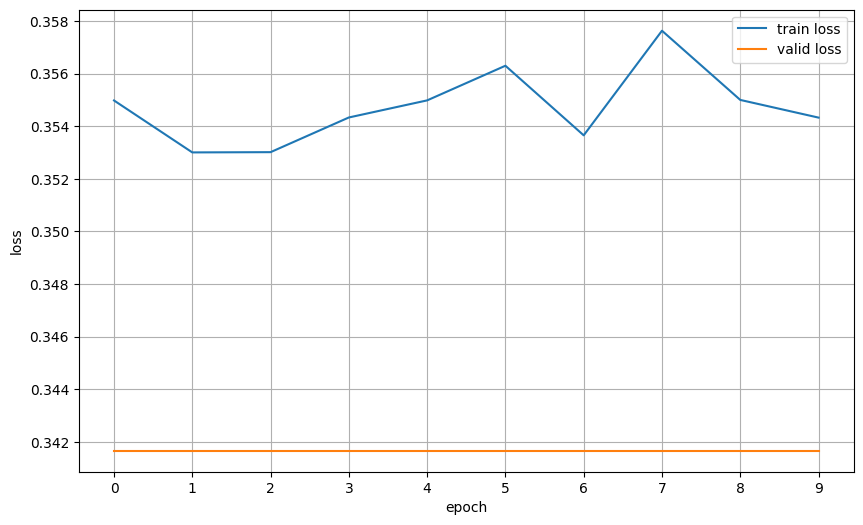

In [531]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")

ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

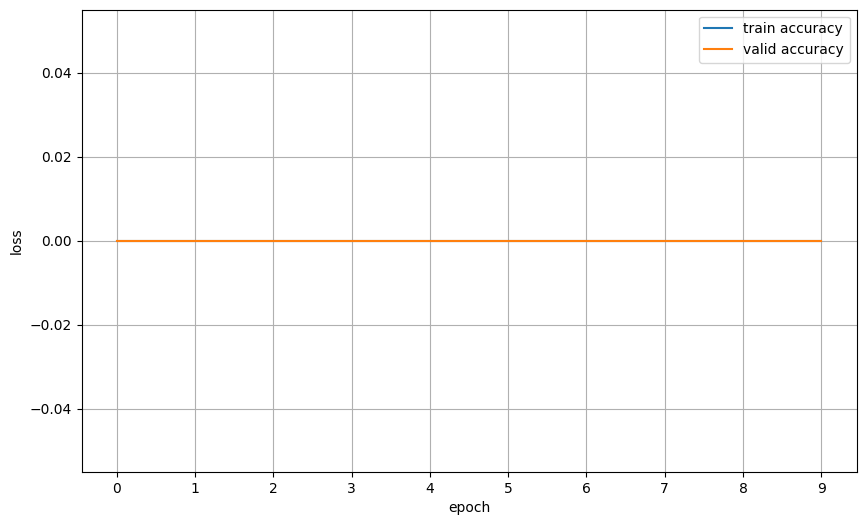

In [532]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()